In [109]:
import numpy as np
import pandas as pd
import statsmodels
import math
import datetime
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

# Cointegration

In [110]:
#function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.01:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [111]:
import datetime as dt
import pandas_datareader.data as web

ls_key = 'Adj Close'
start= dt.datetime(2007,12,1)
end= dt.datetime(2017,12,1)

stocks = ['SHW','CSX','CLX','GIS','BDX',\
          'JNJ','HPQ','WMB','JPM','BAC',\
          'AAPL','OXY','CAG','T','VZ',\
          'SPY','EBAY','MSFT','IBM','JNPR',\
          'NVDA','GS','PGR','BK','COST',\
          'CSCO','HD','LMT','NOC','GPS']

df=web.DataReader(stocks,'yahoo',start,end)
cleanData = df[ls_key]


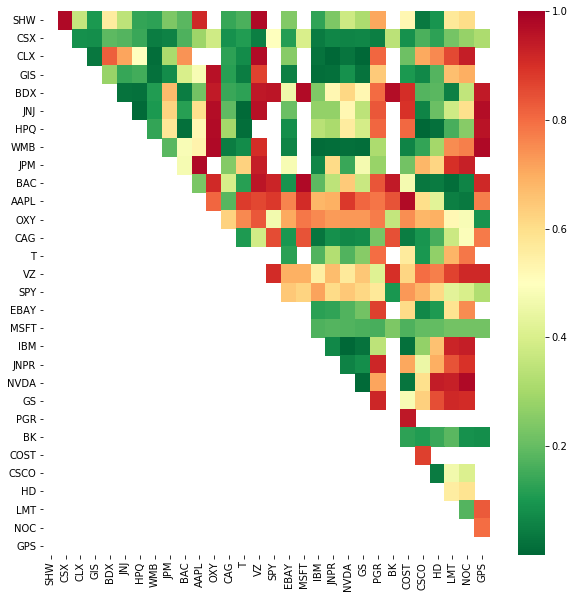

[('BDX', 'LMT'), ('BDX', 'NOC'), ('CLX', 'COST'), ('CLX', 'HD'), ('COST', 'SHW'), ('JPM', 'MSFT'), ('MSFT', 'NOC')]


In [112]:
#HeatMap shows level of cointegration
#print out cointegrated pairs, i.e. p-values <.05

scores, pvalues, pairs = find_cointegrated_pairs(cleanData)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
plt.figure(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=stocks, 
                yticklabels=stocks, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.98)
                )
plt.show()
print(pairs)

# Return

In [113]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [114]:
ratios = cleanData[pairs[0][0]] / cleanData[pairs[0][1]]
print(len(ratios))
train = ratios[:1762]
test = ratios[1762:]

2519


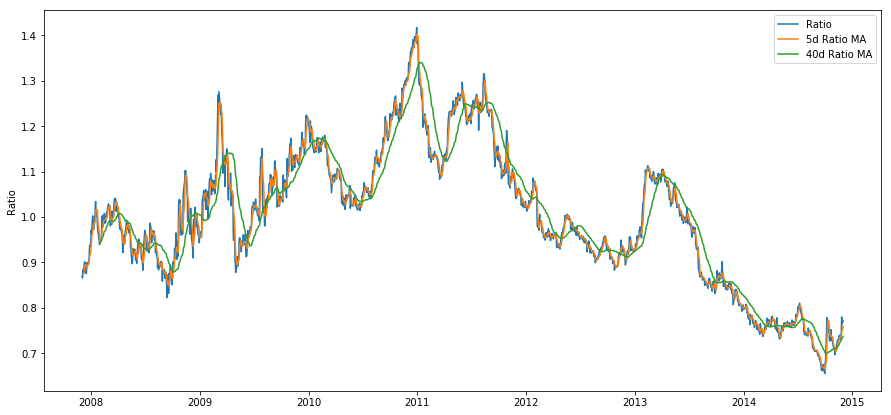

In [115]:
ratios_mavg5 = train.rolling(window=5,
                               center=False).mean()

ratios_mavg40 = train.rolling(window=40,
                               center=False).mean()

std_40 = train.rolling(window=40,
                        center=False).std()

zscore_40_5 = (ratios_mavg5 - ratios_mavg40)/std_40
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg40.index, ratios_mavg40.values)

plt.legend(['Ratio','5d Ratio MA', '40d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

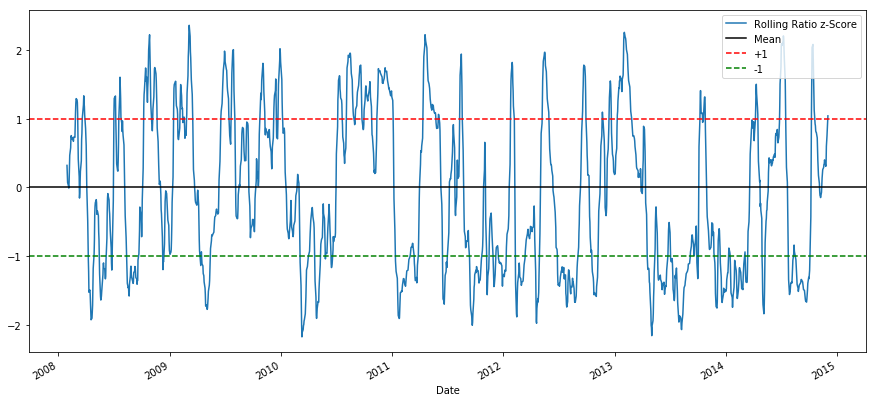

In [116]:
plt.figure(figsize=(15,7))
zscore_40_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

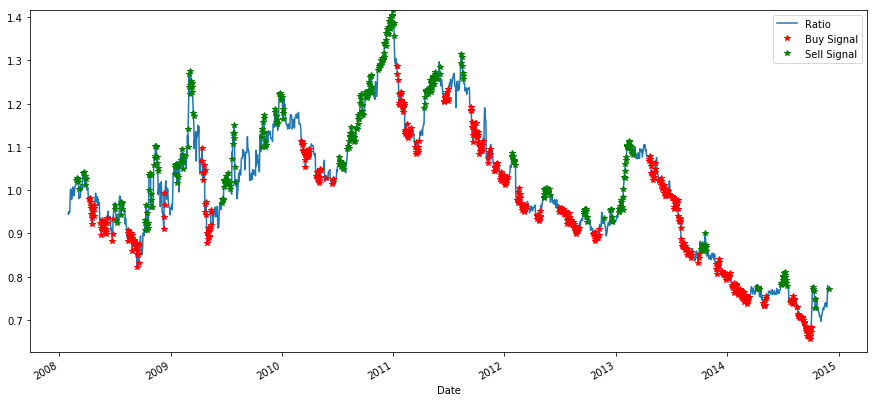

In [117]:
plt.figure(figsize=(15,7))

train[40:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_40_5>-1] = 0
sell[zscore_40_5<1] = 0
buy[40:].plot(color="r",linestyle="None", marker="*")
sell[40:].plot(color="g",linestyle="None", marker="*")
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(["Ratio", "Buy Signal", "Sell Signal"])
plt.show()

# Trading Strategy

In [118]:
def BID_ASK(series):
    prices = pd.DataFrame(series)
    daily_return = prices.pct_change(1) 
    Scov = statsmodels.tsa.stattools.acovf(daily_return,missing='drop',fft=True)
    spread = np.zeros(len(Scov))
    for i in range(0,len(Scov)):
        if Scov[i]<0:
            spread[i] = 2*math.sqrt(-Scov[i])
        else:
            spread[i] = 0
    return spread

In [119]:
# Trade using a MA
def trade(S1, S2, window1, window2,zscore_high,zscore_low):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    BA1 = BID_ASK(S1)
    BA2 = BID_ASK(S2)
    
    pnl_ls = []
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)-1):
        # Sell short if the z-score is > 1
        if zscore[i] > zscore_high:
            money += S1[i] - S2[i] * ratios[i] - BA1[i] - BA2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < zscore_low:
            money -= S1[i] - S2[i] * ratios[i] - BA1[i] - BA2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < zscore_high/2:
            money += S1[i] * countS1 + S2[i] * countS2 - BA1[i] * countS1 - BA2[i]* countS2
            countS1 = 0
            countS2 = 0
        pnl = money
        pnl_ls.append(pnl)
            
    return money, pnl_ls


In [120]:
pnl_df = pd.DataFrame()

for i in range(0,len(pairs)):
    totalPnL, cumPnL = trade(cleanData[pairs[i][0]].iloc[:1763],cleanData[pairs[i][1]].iloc[:1763],5,40,1,-1)
    pnl_df[i] = cumPnL
pnl_df['Total'] = pnl_df.sum(axis=1)

/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


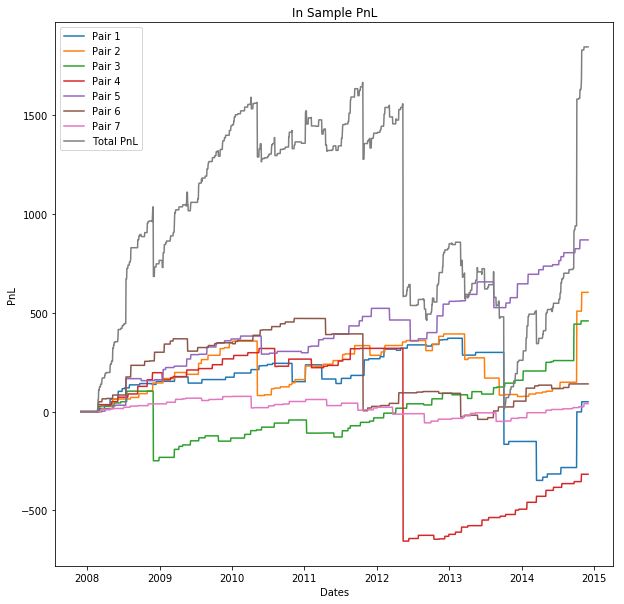

In [121]:
dates = pd.date_range(start='12/1/2007',end='12/1/2014',periods=1762)

plt.figure(figsize=(10,10))
plt.plot(dates,pnl_df)
plt.title("In Sample PnL")
plt.legend(('Pair 1','Pair 2','Pair 3','Pair 4','Pair 5','Pair 6','Pair 7',"Total PnL"))
plt.ylabel('PnL')
plt.xlabel('Dates')
plt.show()

In [122]:
pnl_df2 = pd.DataFrame()

for i in range(0,len(pairs)):
    totalPnL, cumPnL = trade(cleanData[pairs[i][0]].iloc[1762:],cleanData[pairs[i][1]].iloc[1762:],5,40,1,-1)
    pnl_df2[i] = cumPnL
pnl_df2['Total'] = pnl_df2.sum(axis=1)

/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


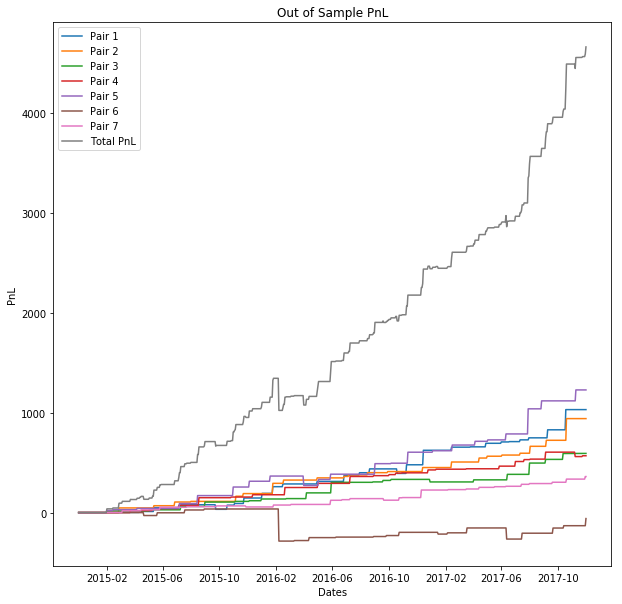

In [123]:
dates = pd.date_range(start='12/2/2014',end='12/1/2017',periods=756)

plt.figure(figsize=(10,10))
plt.plot(dates,pnl_df2)
plt.title("Out of Sample PnL")
plt.legend(('Pair 1','Pair 2','Pair 3','Pair 4','Pair 5','Pair 6','Pair 7',"Total PnL"))
plt.ylabel('PnL')
plt.xlabel('Dates')
plt.show()

# Trading Strategy with Refinement

In [124]:
# Trade using a MA, weighted for signal strength
def trade_weighted(S1, S2, window1, window2,zscore_high,zscore_low):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    BA1 = BID_ASK(S1)
    BA2 = BID_ASK(S2)
    
    pnl_ls = []
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)-1):
        # Sell short if the z-score is > 1
        if zscore[i] > zscore_high:
            money += ( S1[i] - S2[i] * ratios[i] - BA1[i]-BA2[i]* ratios[i] ) * zscore[i]
            countS1 -= 1 * zscore[i]
            countS2 += ratios[i] * zscore[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < zscore_low:
            money -= ( S1[i] - S2[i] * ratios[i] - BA1[i]-BA2[i]* ratios[i] ) * -zscore[i]
            countS1 += 1 * -zscore[i]
            countS2 -= ratios[i] * -zscore[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < zscore_high/2:
            money += S1[i] * countS1 + S2[i] * countS2 - BA1[i] * countS1 - BA2[i] * countS2
            countS1 = 0
            countS2 = 0
        pnl = money
        pnl_ls.append(pnl)
            
    return money, pnl_ls

In [125]:
pnl_df_weighted = pd.DataFrame()

for i in range(0,len(pairs)):
    totalPnL_weighted, cumPnL_weighted = trade_weighted(cleanData[pairs[i][0]].iloc[:1763],cleanData[pairs[i][1]].iloc[:1763],5,40,1,-1)
    pnl_df_weighted[i] = cumPnL_weighted
pnl_df_weighted['Total'] = pnl_df_weighted.sum(axis=1)

/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


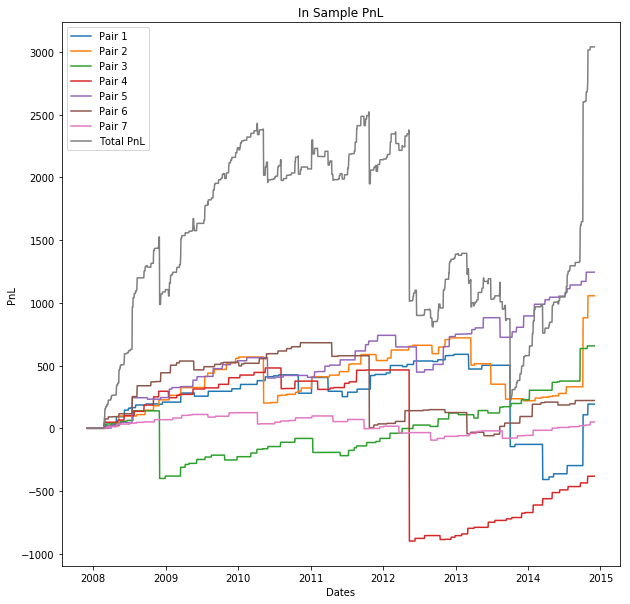

In [126]:
dates = pd.date_range(start='12/1/2007',end='12/1/2014',periods=1762)

plt.figure(figsize=(10,10))
plt.plot(dates,pnl_df_weighted)
plt.title("In Sample PnL")
plt.legend(('Pair 1','Pair 2','Pair 3','Pair 4','Pair 5','Pair 6','Pair 7',"Total PnL"))
plt.ylabel('PnL')
plt.xlabel('Dates')
plt.show()

In [127]:
pnl_df2_weighted = pd.DataFrame()

for i in range(0,len(pairs)):
    totalPnL_weighted, cumPnL_weighted = trade_weighted(cleanData[pairs[i][0]].iloc[1762:],cleanData[pairs[i][1]].iloc[1762:],5,40,1,-1)
    pnl_df2_weighted[i] = cumPnL_weighted
pnl_df2_weighted['Total'] = pnl_df2_weighted.sum(axis=1)

/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


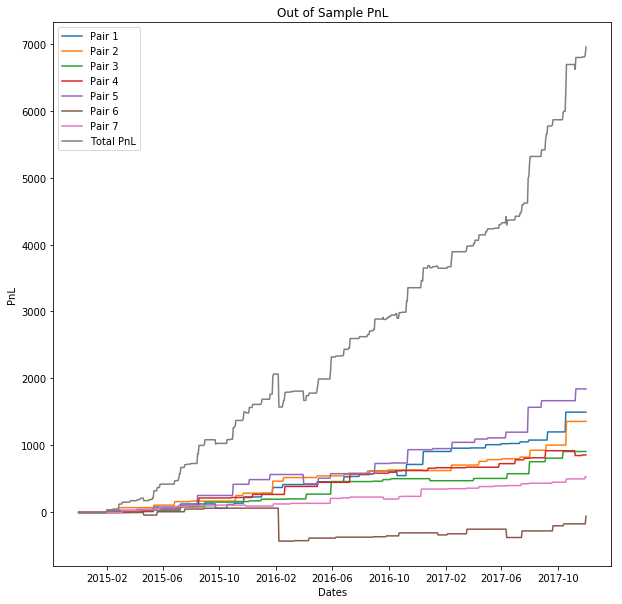

In [128]:
dates = pd.date_range(start='12/2/2014',end='12/1/2017',periods=756)

plt.figure(figsize=(10,10))
plt.plot(dates,pnl_df2_weighted)
plt.title("Out of Sample PnL")
plt.legend(('Pair 1','Pair 2','Pair 3','Pair 4','Pair 5','Pair 6','Pair 7',"Total PnL"))
plt.ylabel('PnL')
plt.xlabel('Dates')
plt.show()